In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'])


In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_d = sales_d.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_d.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,96684,371027,879515
1,2019-02-01,99187,380632,902285
2,2019-03-01,113711,436369,1034407
3,2019-04-01,103982,399033,945904
4,2019-05-01,101826,390760,926291


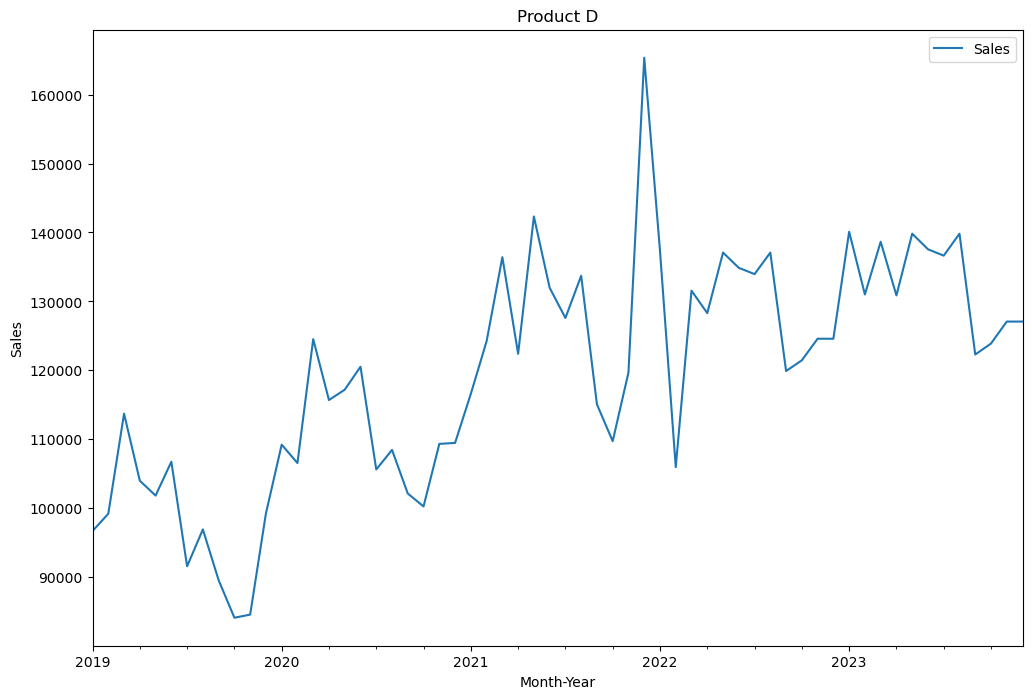

In [5]:
ax = sales_d.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product D')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_d[:54]
test=sales_d[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing
23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing
23:48:11 - cmdstanpy - INFO - Chain [1] start processing
23:48:13 - cmdstanpy - INFO - Chain [1] done processing
23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:17 - cmdstanpy - INFO - Chain [1] done processing
23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing
23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing
23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   13656.329709  
1   14887.373268  
2   18057.484917  
3   17793.675987  
4   19539.933777  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
12,0.010,0.01,additive,13296.519626
36,0.200,0.01,additive,13546.858304
48,0.300,0.01,additive,13612.218082
0,0.001,0.01,additive,13656.329709
60,0.500,0.01,additive,13671.762263
...,...,...,...,...
57,0.300,5.00,multiplicative,42719.267186
69,0.500,5.00,multiplicative,82889.116157
71,0.500,10.00,multiplicative,85495.474708
65,0.500,1.00,multiplicative,87966.756386


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.010, seasonality_prior_scale=0.01, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

00:12:43 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_d['Market Size']
future_dates['Marketing Expense'] = sales_d['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,371027,879515
1,2019-02-01,380632,902285
2,2019-03-01,436369,1034407
3,2019-04-01,399033,945904
4,2019-05-01,390760,926291
5,2019-06-01,409602,970956
6,2019-07-01,351390,832967
7,2019-08-01,371925,881644
8,2019-09-01,343654,814628
9,2019-10-01,324474,769162


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,140787.138988,126391.145149,155744.890561
55,2023-08-01,144468.274563,129427.515968,158615.684275
56,2023-09-01,134163.765791,119782.593839,148245.876235
57,2023-10-01,133285.722981,118834.948665,147808.420757
58,2023-11-01,134519.001198,120169.479915,149826.051113
59,2023-12-01,147872.640114,131730.839479,162007.996846


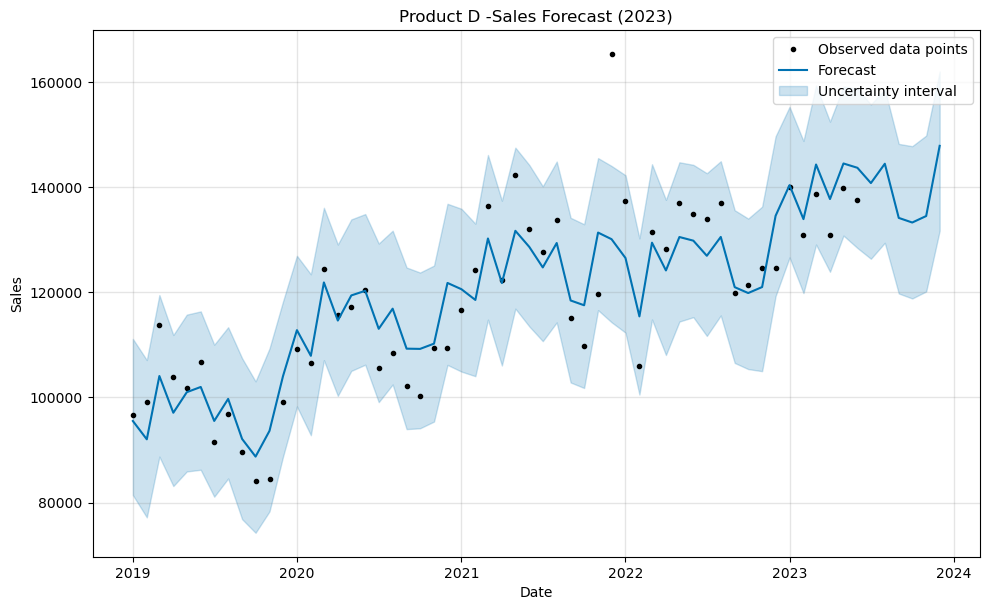

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product D -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

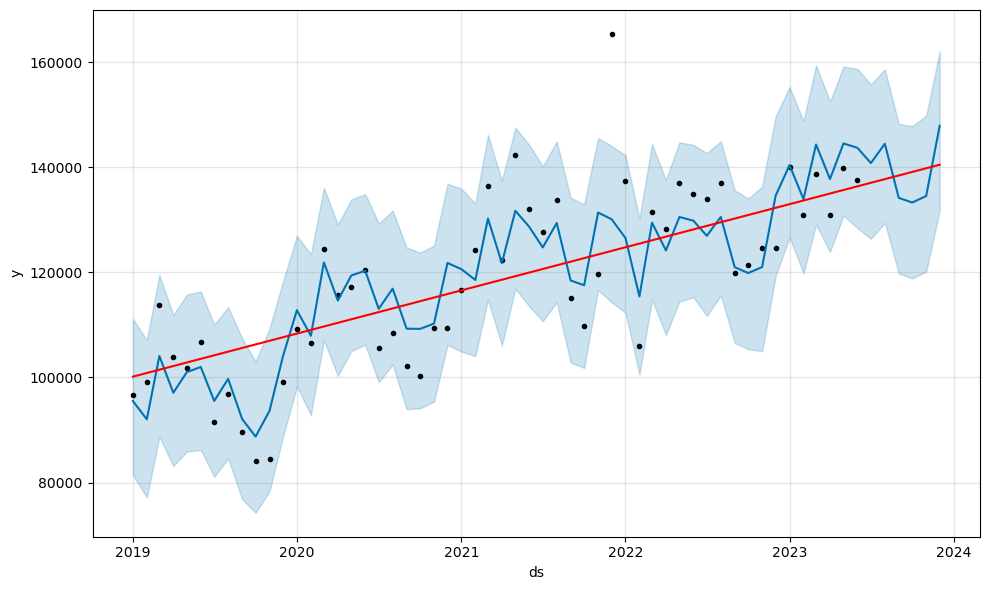

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

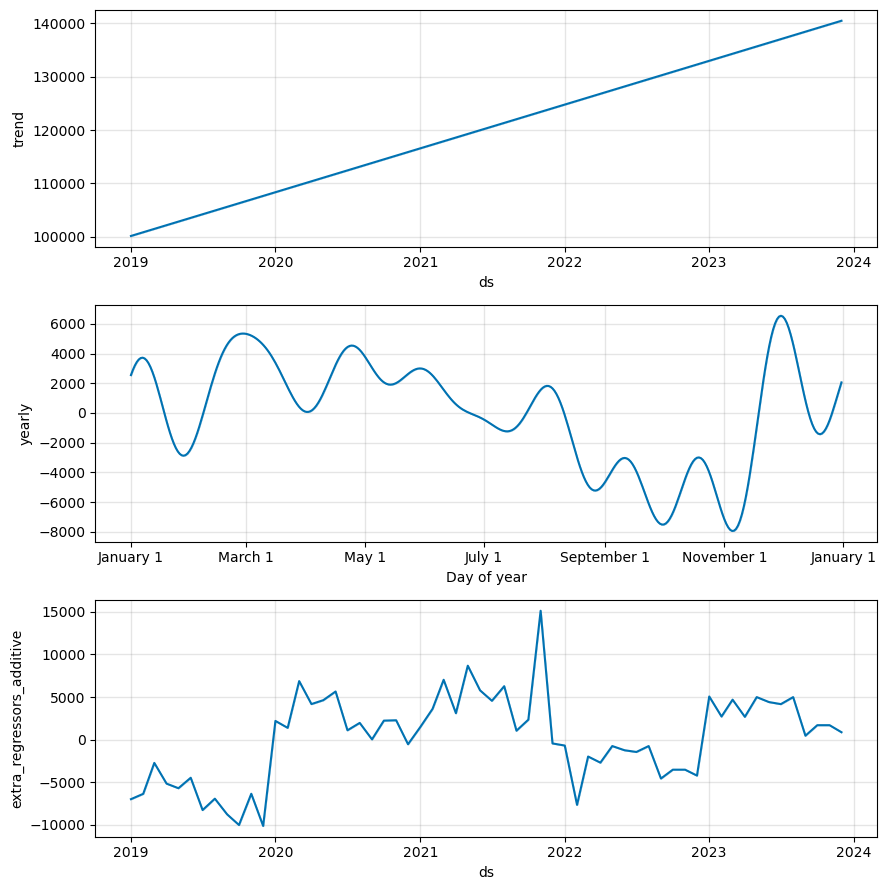

In [21]:
fig2 = model.plot_components(forecast)

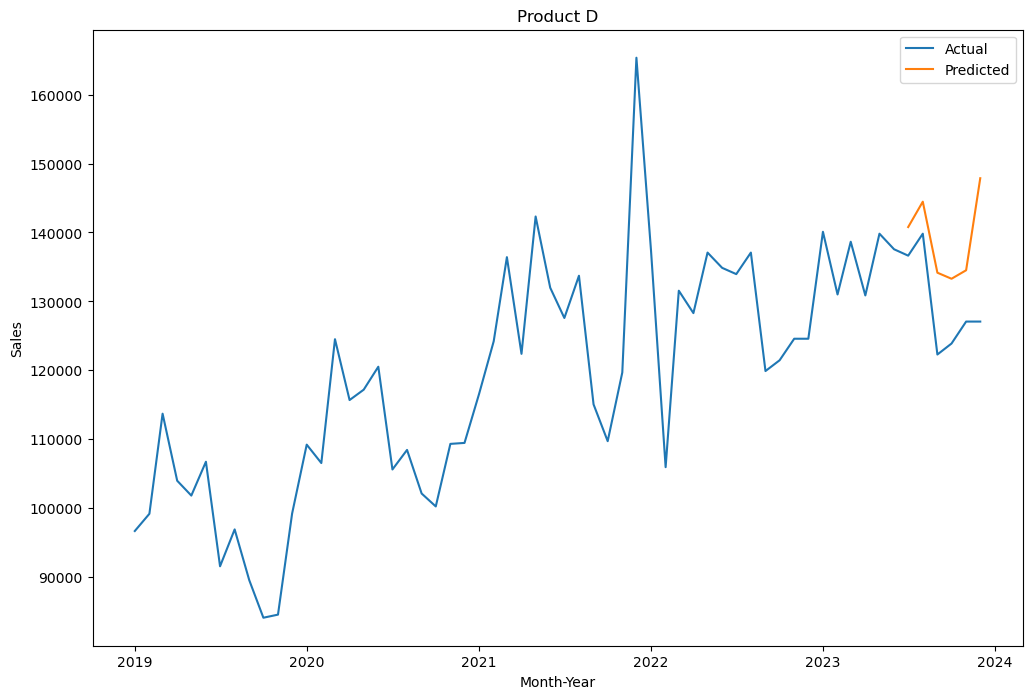

In [22]:
# Reset index of sales_b DataFrame
sales_d_reset_index = sales_d.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_d_reset_index['ds'], sales_d_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product D')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 9717.924
MAPE - FB PROPHET: 0.076
MSE - FB PROPHET: 126009247.900
RMSE - FB PROPHET: 11225.384


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,5.524764e+07,7432.875506,6107.740560,0.044987,0.044987,0.046515,1.0
1,25 days,6.033228e+07,7767.385617,7020.684539,0.051454,0.051454,0.053121,1.0
2,29 days,3.798715e+07,6163.371259,5795.407127,0.041970,0.041970,0.041392,1.0
3,51 days,3.484809e+07,5903.226946,5306.231650,0.038337,0.038337,0.037669,1.0
4,55 days,8.273084e+07,9095.649479,7645.903442,0.069501,0.069501,0.066282,1.0
5,56 days,8.410479e+07,9170.866536,7878.614882,0.070949,0.070949,0.067763,1.0
6,60 days,5.859199e+07,7654.540808,6765.420081,0.051103,0.051103,0.049740,1.0
7,82 days,5.571048e+07,7463.945285,6219.423982,0.048581,0.048581,0.046999,1.0
8,83 days,2.304768e+06,1518.146225,1286.092369,0.010916,0.010916,0.010838,1.0
9,87 days,1.544931e+07,3930.561434,3008.676171,0.024917,0.024917,0.024399,1.0


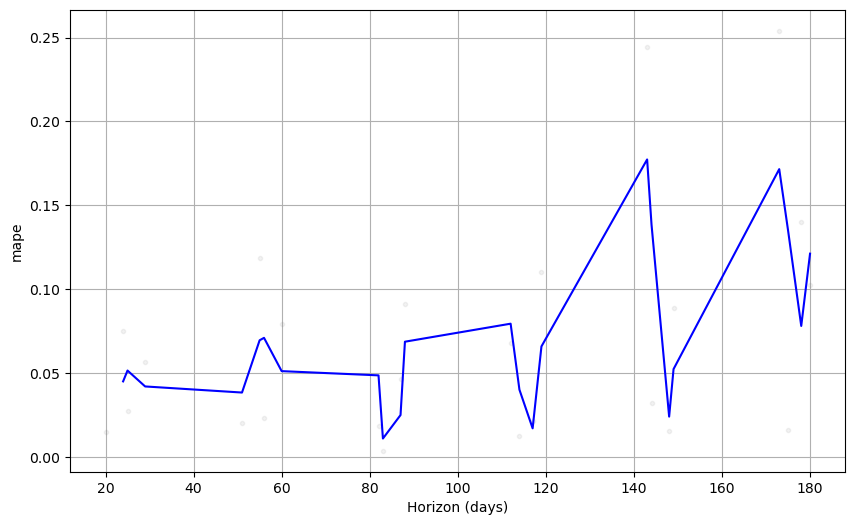

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54    136637
55    139824
56    122293
57    123887
58    127074
59    127074
Name: y, dtype: int64

In [30]:
pred

54    140787.138988
55    144468.274563
56    134163.765791
57    133285.722981
58    134519.001198
59    147872.640114
Name: yhat, dtype: float64